In [1]:
# libraries
import warnings
import pandas as pd

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder, StandardScaler
from pyspark.sql import SparkSession

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [3]:
spark_df = spark.read.csv('train.csv', inferSchema=True, header=True)
spark_df.show(5)

+------+--------------------+--------------------+------------+-----------+--------+----------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+
|TARGET|              CST_NR|               CC_NR|DAY_OF_MONTH|DAY_OF_WEEK|TXN_TIME|TXN_SOURCE|             TXN_TRM|           TXN_ENTRY|TXN_AMNT|                CITY|             COUNTRY|             MC_NAME|               MC_ID|            MCC_CODE|
+------+--------------------+--------------------+------------+-----------+--------+----------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   0.0|c64007916f81cb954...|bf4e876751b878515...|         8.0|        4.0|  1800.0|         O|4a1917677530762f2...|12d7720f7273e2a1c...|   540.0|8c1e38274fba4c211...|368a2b6e4893c8ab0...|09adaccd88433a530...|e0d92b0729b140698...|9bcde6cbc90213

In [4]:
print("Shape: ", (spark_df.count(), len(spark_df.columns)))

Shape:  (607507, 15)


In [5]:
spark_df.printSchema() #types of Variables

root
 |-- TARGET: double (nullable = true)
 |-- CST_NR: string (nullable = true)
 |-- CC_NR: string (nullable = true)
 |-- DAY_OF_MONTH: double (nullable = true)
 |-- DAY_OF_WEEK: double (nullable = true)
 |-- TXN_TIME: double (nullable = true)
 |-- TXN_SOURCE: string (nullable = true)
 |-- TXN_TRM: string (nullable = true)
 |-- TXN_ENTRY: string (nullable = true)
 |-- TXN_AMNT: double (nullable = true)
 |-- CITY: string (nullable = true)
 |-- COUNTRY: string (nullable = true)
 |-- MC_NAME: string (nullable = true)
 |-- MC_ID: string (nullable = true)
 |-- MCC_CODE: string (nullable = true)



In [6]:
spark_df.describe(["TXN_TRM"]).show()

+-------+--------------------+
|summary|             TXN_TRM|
+-------+--------------------+
|  count|              607507|
|   mean|                null|
| stddev|                null|
|    min|4a1917677530762f2...|
|    max|4a1917677530762f2...|
+-------+--------------------+



In [7]:
spark_df.groupby("TXN_TRM").count().show()

+--------------------+------+
|             TXN_TRM| count|
+--------------------+------+
|4a1917677530762f2...|607507|
+--------------------+------+



In [8]:
columns_to_drop = ['TXN_TRM']
spark_df = spark_df.drop(*columns_to_drop)

In [9]:
spark_df.show(5)

+------+--------------------+--------------------+------------+-----------+--------+----------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+
|TARGET|              CST_NR|               CC_NR|DAY_OF_MONTH|DAY_OF_WEEK|TXN_TIME|TXN_SOURCE|           TXN_ENTRY|TXN_AMNT|                CITY|             COUNTRY|             MC_NAME|               MC_ID|            MCC_CODE|
+------+--------------------+--------------------+------------+-----------+--------+----------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   0.0|c64007916f81cb954...|bf4e876751b878515...|         8.0|        4.0|  1800.0|         O|12d7720f7273e2a1c...|   540.0|8c1e38274fba4c211...|368a2b6e4893c8ab0...|09adaccd88433a530...|e0d92b0729b140698...|9bcde6cbc90213586...|
|   0.0|24882e5a50d43c050...|933c28d9d4c6fb6db...|        11.0|        7.0| 

In [10]:
spark_df.select("TARGET").distinct().show()

+------+
|TARGET|
+------+
|   0.0|
|   1.0|
+------+



In [11]:
num_cols = [col[0] for col in spark_df.dtypes if col[1] != 'string']
spark_df.select(num_cols).describe().show() 

+-------+--------------------+-----------------+------------------+------------------+------------------+
|summary|              TARGET|     DAY_OF_MONTH|       DAY_OF_WEEK|          TXN_TIME|          TXN_AMNT|
+-------+--------------------+-----------------+------------------+------------------+------------------+
|  count|              607507|           607507|            607507|            607507|            607391|
|   mean|0.006064127656142234|10.64453413705521| 4.031207870855809|1434.6514673904992|479.29211990299495|
| stddev| 0.07763609942149745| 5.74144331272658|1.9863533004906548| 596.4313362735044|10471.584699228084|
|    min|                 0.0|              1.0|               1.0|               0.0|               0.0|
|    max|                 1.0|             20.0|               7.0|            2359.0|         4792970.0|
+-------+--------------------+-----------------+------------------+------------------+------------------+



In [12]:
cat_cols = [col[0] for col in spark_df.dtypes if col[1] == 'string']
spark_df.select(cat_cols).describe().show() 

+-------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|summary|              CST_NR|               CC_NR|TXN_SOURCE|           TXN_ENTRY|                CITY|             COUNTRY|             MC_NAME|               MC_ID|            MCC_CODE|
+-------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  count|              607507|              607507|    607507|              607507|              607507|              607507|              607507|              607507|              607507|
|   mean|                null|                null|      null|                null|                null|                null|                null|                null|                null|
| stddev|                null|                null|    

In [13]:
from pyspark.sql.functions import when, count, col
spark_df.select([count(when(col(c).isNull(), c)).alias(c) for c in spark_df.columns]).toPandas().T

,0
TARGET,0
CST_NR,0
CC_NR,0
DAY_OF_MONTH,0
DAY_OF_WEEK,0
TXN_TIME,0
TXN_SOURCE,0
TXN_ENTRY,0
TXN_AMNT,116
CITY,0


In [14]:
spark_df = spark_df.fillna({'TXN_AMNT':'0'})

In [15]:
spark_df.select([count(when(col(c).isNull(), c)).alias(c) for c in spark_df.columns]).toPandas().T

,0
TARGET,0
CST_NR,0
CC_NR,0
DAY_OF_MONTH,0
DAY_OF_WEEK,0
TXN_TIME,0
TXN_SOURCE,0
TXN_ENTRY,0
TXN_AMNT,0
CITY,0


In [16]:
spark_df = spark_df.toDF(*[c.lower() for c in spark_df.columns])
spark_df.show(5)

+------+--------------------+--------------------+------------+-----------+--------+----------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+
|target|              cst_nr|               cc_nr|day_of_month|day_of_week|txn_time|txn_source|           txn_entry|txn_amnt|                city|             country|             mc_name|               mc_id|            mcc_code|
+------+--------------------+--------------------+------------+-----------+--------+----------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   0.0|c64007916f81cb954...|bf4e876751b878515...|         8.0|        4.0|  1800.0|         O|12d7720f7273e2a1c...|   540.0|8c1e38274fba4c211...|368a2b6e4893c8ab0...|09adaccd88433a530...|e0d92b0729b140698...|9bcde6cbc90213586...|
|   0.0|24882e5a50d43c050...|933c28d9d4c6fb6db...|        11.0|        7.0| 

In [17]:
spark_df = spark_df.drop('mc_name')

In [18]:
#converting float values to integer
spark_df = spark_df.withColumn("TXN_AMNT", spark_df["TXN_AMNT"].cast("integer"))

In [19]:
train_string_columns = []

for col, dtype in spark_df.dtypes:
    if dtype == 'string':
        train_string_columns.append(col)

In [20]:
train_df = spark_df
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

indexers = [StringIndexer(inputCol=column, outputCol=column+'_index', handleInvalid='keep').fit(train_df) for column in train_string_columns]


pipeline = Pipeline(stages=indexers)
train_indexed = pipeline.fit(train_df).transform(train_df)

In [21]:
def get_dtype(df,colname):
    return [dtype for name, dtype in df.dtypes if name == colname][0]

num_cols_train = []
for col in train_indexed.columns:
    if get_dtype(train_indexed,col) != 'string':
        num_cols_train.append(str(col))
        
train_indexed = train_indexed.select(num_cols_train)

In [22]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = train_indexed.drop("target").columns, outputCol = 'features').setHandleInvalid("keep")

train_vector = vectorAssembler.transform(train_indexed)

In [23]:
train_vector

DataFrame[target: double, day_of_month: double, day_of_week: double, txn_time: double, TXN_AMNT: int, cst_nr_index: double, cc_nr_index: double, txn_source_index: double, txn_entry_index: double, city_index: double, country_index: double, mc_id_index: double, mcc_code_index: double, features: vector]

In [24]:
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import ClusteringEvaluator

In [34]:
cost = np.zeros(7)
for k in range(2,7):
    print(k)
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(train_vector.sample(False,0.1))
    predictions = model.transform(train_vector)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    print("Silhouette with squared euclidean distance = " + str(silhouette))
    summary = model.summary
    cost[k] = summary.trainingCost

2
Silhouette with squared euclidean distance = 0.8036328641866486
3
Silhouette with squared euclidean distance = 0.7600937462517264
4
Silhouette with squared euclidean distance = 0.6676824227824018
5
Silhouette with squared euclidean distance = 0.7222505881854742
6
Silhouette with squared euclidean distance = 0.6952899859708339


Text(0, 0.5, 'cost')

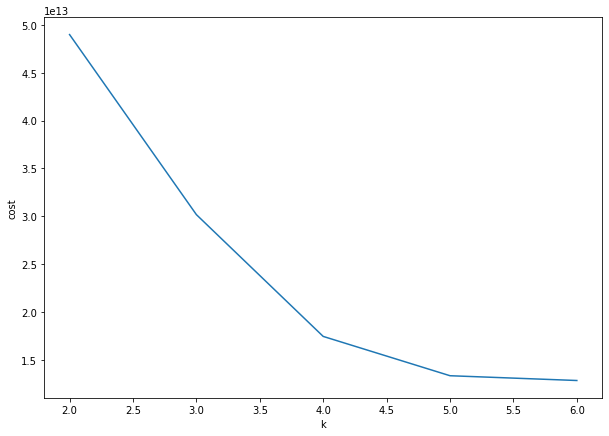

In [36]:
fig, ax = plt.subplots(1,1, figsize =(10,7))
ax.plot(range(2,7),cost[2:7])
ax.set_xlabel('k')
ax.set_ylabel('cost')